# Try importing parquet data into tensorflow

In [1]:
%config Completer.use_jedi = False

Later we will want to preprocess these logs, but for now lets just see that we can feed this into a trainer.

In [2]:
import os
import pprint
import tempfile
import urllib

import absl
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

from tfx import v1 as tfx
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

In [3]:
# Uncomment the following to disable GPU
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.6.2
TFX version: 1.3.3


In [5]:
context = InteractiveContext()

In [6]:
import tensorflow_io as tfio

In [7]:
files = tf.data.Dataset.list_files("/var/log/fancontrol/featurelog/*/*/*/*")

In [8]:
# To use the flat_map or interlieve on files we need to specify the columns in the from_parquet
# So we read in one file to get the column schema first
one = tfio.IODataset.from_parquet(files.as_numpy_iterator().next())
columns = one.element_spec
print(columns)

OrderedDict([(b'timestamp', TensorSpec(shape=(), dtype=tf.float64, name=None)), (b'label', TensorSpec(shape=(), dtype=tf.string, name=None)), (b'cpuinfo.list.item', TensorSpec(shape=(), dtype=tf.float32, name=None)), (b'profile.list.item', TensorSpec(shape=(), dtype=tf.float32, name=None)), (b'cpu_idle.list.item', TensorSpec(shape=(), dtype=tf.float64, name=None)), (b'cpu_user.list.item', TensorSpec(shape=(), dtype=tf.float64, name=None)), (b'cpu_system.list.item', TensorSpec(shape=(), dtype=tf.float64, name=None)), (b'cpu_nice.list.item', TensorSpec(shape=(), dtype=tf.float64, name=None)), (b'power_constraints.list.item', TensorSpec(shape=(), dtype=tf.float32, name=None)), (b'power.list.item', TensorSpec(shape=(), dtype=tf.float32, name=None)), (b'temp.list.item', TensorSpec(shape=(), dtype=tf.float32, name=None)), (b'fan_rpm.list.item', TensorSpec(shape=(), dtype=tf.float32, name=None))])


In [9]:
oneb = one.batch(1)
onef = next(iter(oneb))
print(onef)
print(onef[b'temp.list.item'])
print(onef[b'label'])

OrderedDict([(b'timestamp', <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.63764967e+09])>), (b'label', <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1'], dtype=object)>), (b'cpuinfo.list.item', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2800.], dtype=float32)>), (b'profile.list.item', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>), (b'cpu_idle.list.item', <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.])>), (b'cpu_user.list.item', <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>), (b'cpu_system.list.item', <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>), (b'cpu_nice.list.item', <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>), (b'power_constraints.list.item', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([28.], dtype=float32)>), (b'power.list.item', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.8681784], dtype=float32)>), (b'temp.list.item', <tf.Tensor: shape=(1,), dtype=float32, numpy=

This does not look correct. We should have 8 cpuinfo.list.item entries and 10 or so temp.list.item entries for every label.
Let's try setting a dimension...

In [10]:
from collections import OrderedDict
from tensorflow import TensorSpec
columns = OrderedDict([
    (b'timestamp', TensorSpec(shape=(None,1), dtype=tf.float64, name=None)),
    (b'label', TensorSpec(shape=(None,1), dtype=tf.string, name=None)),
    (b'cpuinfo.list.item', TensorSpec(shape=(None,8), dtype=tf.float32, name=None)),
    (b'profile.list.item', TensorSpec(shape=(None,1), dtype=tf.float32, name=None)),
    (b'cpu_idle.list.item', TensorSpec(shape=(None,8), dtype=tf.float64, name=None)),
    (b'cpu_user.list.item', TensorSpec(shape=(None,8), dtype=tf.float64, name=None)),
    (b'cpu_system.list.item', TensorSpec(shape=(None,8), dtype=tf.float64, name=None)),
    (b'cpu_nice.list.item', TensorSpec(shape=(None,8), dtype=tf.float64, name=None)),
    (b'power_constraints.list.item', TensorSpec(shape=(None,2), dtype=tf.float32, name=None)),
    (b'power.list.item', TensorSpec(shape=(None,1), dtype=tf.float32, name=None)),
    (b'temp.list.item', TensorSpec(shape=(None,10), dtype=tf.float32, name=None)),
    (b'fan_rpm.list.item', TensorSpec(shape=(None,1), dtype=tf.float32, name=None))])

In [11]:
ds = files.interleave(lambda floc: tfio.IODataset.from_parquet(floc, columns=columns),
    #cycle_length=4,
                      num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=False)

In [12]:
dsb = ds.batch(200)
features = next(iter(dsb))
print(features)
print(features[b'temp.list.item'])
print(features[b'label'])

OrderedDict([(b'timestamp', <tf.Tensor: shape=(200,), dtype=float64, numpy=
array([1.63767274e+09, 1.63775717e+09, 1.63758397e+09, 1.63767274e+09,
       1.63758397e+09, 1.63767274e+09, 1.63758397e+09, 1.63767274e+09,
       1.63758397e+09, 1.63767274e+09, 1.63758397e+09, 1.63767274e+09,
       1.63758397e+09, 1.63767274e+09, 1.63758397e+09, 1.63767274e+09,
       1.63758397e+09, 1.63767274e+09, 1.63758397e+09, 1.63767274e+09,
       1.63767274e+09, 1.63758397e+09, 1.63767274e+09, 1.63758397e+09,
       1.63767274e+09, 1.63767274e+09, 1.63758397e+09, 1.63767274e+09,
       1.63767274e+09, 1.63767274e+09, 1.63767274e+09, 1.63758397e+09,
       1.63767274e+09, 1.63758397e+09, 1.63767274e+09, 1.63767274e+09,
       1.63758397e+09, 1.63767274e+09, 1.63758397e+09, 1.63767274e+09,
       1.63758397e+09, 1.63767274e+09, 1.63758397e+09, 1.63767274e+09,
       1.63767274e+09, 1.63758397e+09, 1.63767274e+09, 1.63758397e+09,
       1.63767274e+09, 1.63758397e+09, 1.63767274e+09, 1.63758397e+09,
 

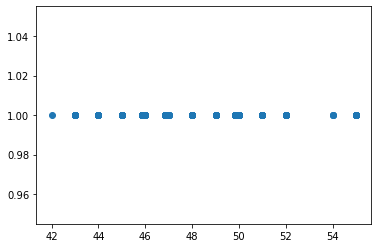

In [13]:
import matplotlib.pyplot as plt
plt.scatter(features[b'temp.list.item'], features[b'label'])

Looks like we have a reasonable sampling of temperatures. But the real problem is that
tfio.IODataset.from_parquet does not appear to recognize list types.

# Can we import parquet data by using pyarrow?

In [16]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import tensorflow as tf
import pyarrow.compute as pc

In [17]:
ds = pq.ParquetDataset("/var/log/fancontrol/featurelog")
table = ds.read()
table.num_rows

868300

In [18]:
ptable = table.to_pandas()

In [19]:
ptable.dtypes

timestamp             float64
label                  object
cpuinfo                object
profile                object
cpu_idle               object
cpu_user               object
cpu_system             object
cpu_nice               object
power_constraints      object
power                  object
temp                   object
fan_rpm                object
year                 category
month                category
day                  category
dtype: object

In [24]:
import numpy as np

In [44]:
features = ptable[['cpuinfo', 'cpu_idle', 'temp', 'power']].apply(lambda row: np.asarray(row))

In [55]:
features_dict = features.to_dict()

This does not work  
dict_ds = tf.data.Dataset.from_tensor_slices((features_dict, ptable['label']))

So lets use from_generator.. first we'll need a function that returns one training pair

In [140]:
def generator():
    feature_names = list(ptable.columns.values)
    feature_names.remove('label')
    for index, row in ptable.iterrows():
        f = [tf.convert_to_tensor(row[k], tf.float32, name=k) for k in feature_names]
        f.append(tf.convert_to_tensor(float(row['label']), tf.float32, name='label'))
        yield tuple(f)

def generator_types():
    return tuple([tf.float32] * len(ptable.columns.values))

In [143]:
all = tf.data.Dataset.from_generator(generator, output_types=generator_types()) \
    .shuffle(10, reshuffle_each_iteration=False)

In [146]:
def is_test(x, y):
    return x % 4 == 0
def is_train(x, y):
    return not is_test(x, y)
recover = lambda x,y: y
test_dataset = all.enumerate() \
                    .filter(is_test) \
                    .map(recover)

train_dataset = all.enumerate() \
                    .filter(is_train) \
                    .map(recover)